In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=10, edgeitems=4)

In [2]:
tile_size = 1024
overlap = 128
y_drop = 240
threshold = 4000

random_pattern = True
# number of PEs compute in the same time
num_PE = 64

In [3]:
# W = {'A': {'A':  91, 'C': -90, 'G': -25, 'T':-100},
#      'C': {'A': -90, 'C': 100, 'G':-100, 'T': -25},
#      'G': {'A': -25, 'C':-100, 'G': 100, 'T': -90},
#      'T': {'A':-100, 'C': -25, 'G': -90, 'T':  91}}
# g_o = -430
# g_e = -30

W = {'A': {'A': 3, 'C':-3, 'G':-1, 'T':-4},
     'C': {'A':-3, 'C': 4, 'G':-4, 'T':-1},
     'G': {'A':-1, 'C':-4, 'G': 4, 'T':-3},
     'T': {'A':-4, 'C':-1, 'G':-3, 'T': 3}}
g_o = -12
g_e = -1

In [4]:
# W = {'A': {'A': 2, 'C':-3, 'G':-3, 'T':-3},
#      'C': {'A':-3, 'C': 2, 'G':-3, 'T':-3},
#      'G': {'A':-3, 'C':-3, 'G': 2, 'T':-3},
#      'T': {'A':-3, 'C':-3, 'G':-3, 'T': 2}}
# g_o = -7
# g_e = -2

In [5]:
# f = open('sequence_1.txt', 'r')
# gene_1 = ''
# f.readline()
# for line in f.readlines():
#     gene_1 = gene_1 + line[:-1]
# f.close()

# f = open('sequence_2.txt', 'r')
# gene_2 = ''
# f.readline()
# for line in f.readlines():
#     gene_2 = gene_2 + line[:-1]
# f.close()

# print(len(gene_1), len(gene_2))

In [6]:
# bias = 0
# gene_1, gene_2 = gene_1[bias:bias+tile_size], gene_2[bias:bias+tile_size]
# print(len(gene_1), len(gene_2))
# print(gene_1)
# print(gene_2)

In [7]:
import random
seed = 6
prob = (2 + seed)/100
random.seed(seed)

d = ['A', 'C', 'G', 'T']
if random_pattern:
    gene_1, gene_2 = '', ''
    for i in range(tile_size):
        gene_1 += d[random.randint(0, 3)]
    i = 0
    while i < tile_size:
        die = random.random()
        l = random.randint(1,8)
        # delete gene_1 for length l
        if die < prob:
            i += l
        # insert gene_1 for length l
        elif die < 2*prob:
            for j in range(l):
                gene_2 += d[random.randint(0, 3)]
            i += 1
        # change 1 gene
        elif die < 3*prob:
            gene_2 += d[random.randint(0, 3)]
            i += 1
        else:
            gene_2 += gene_1[i]
            i += 1
    while len(gene_2) < tile_size:
        gene_2 += d[random.randint(0, 3)]
            
    print(len(gene_1), len(gene_2))
    print(gene_1)
    print(gene_2)

1024 1024
ATGAACTGGAGTCTACGATGAGTGTACGAACGTCAGCTGGAACAGGCTTCCCACCAGGGTTGCTACTTATCATTTATTGTACGTTCAAAGGCGTGGTTTGTTTCTTGTGGCTGGTTCGATACAAGGTACCGATTATCAGGCCGCAAAATTAACACGTTACCTTTTGTAGGGGAAGGGTTTGAACCACGGAACTGACATCTTACAGACCCGCTCCCTCGCATCGTTATCCGGCCCCTAAAATAAAGAACTCGATAACTAACAATGGTCCCGAGGAAGGACAGGTAGCAAGATATGAGCCCTCCTTTGGCGACTACAACACTTTTCTCTAGTGGCGGGCAGCATCACTTCCATGGTGAGCAACAAAACGGCCCCCCTTACTCGCGGAGAAATTGAAGATGAGCCGTTACATGACTGATATCCTGGGGGTACATGCAGACGCCGAGGGCCAAGCGCTCTTGAATACTGCATGGGGTGATCGAGAAAATTACGGAAGGGTTAAGTTGGCAATCCGAAGCAATGTCAGCCCAACGTTTTGTCCACCTCGTGCCATCTAAGGTGTTGGGATCGGTCATCGTTGATTTAAATTAAGGCCTATAAGCGGTGAGTGCTGAACAAATATTGTCCGCACACGTCGTGCGGCACCTATAAAACATGCTCACGCGCAAGATCCTTATCCCGTGTATCCGCTGAGGGTTGTGCGCTCACACGTACGAATTAGGCGAGCGGAGAACGCCATAGGCTTAACCCGCGCGGGCCACTAAAAGGTTGCTTGTTCAATTATGCAAACCTCAGCAATAGTACTCAATGCCTTTCGCATTACGGAGCGGGGTTGTGCATGACGAAACAGATACCAAGCCCACAGTAAGCTCTGATGTAGGCACGACAGGACGTGACGATTAGGCATGACAAAAGATACGGGCCCGGCAACTATTTGCACGCACGATGGCTCAGCCCCACTCTATTAAGAGTTCATTATCATAAAAACCCCTC

In [8]:
# tile_size = 52
# gene_1 = gene_1[:tile_size]
# gene_2 = gene_2[:tile_size]
# print(gene_1)
# print(gene_2)

# Normal version

In [9]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + (i-1)*g_e
    I[0, i] = g_o + (i-1)*g_e
    I[i, 0] = float('-inf')
# print('Score matrix')
# print(V)
# print('Insertion matrix (Score when direction is left)')
# print(I)
# print('Deletion matrix (Score when direction is top)')
# print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

In [10]:
V_max = float('-inf')
x_max, y_max = 0, 0
i,j = 1,1

for i in range(1, tile_size+1):
    for j in range(1, tile_size+1):
        V_nxt = V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]]
        I[i][j] = max(V[i][j-1]+g_o, I[i][j-1]+g_e)
        D[i][j] = max(V[i-1][j]+g_o, D[i-1][j]+g_e)
        V[i][j] = max(V_nxt, I[i][j], D[i][j])
        # if new maximum
        if V[i][j] >= V_max:
            V_max = V[i][j]
            x_max, y_max = i, j
        # direction of Trace
        if V[i][j] == V_nxt:
            Trace[i][j] = 1
        elif V[i][j] == D[i][j]:
            Trace[i][j] = 2
        elif V[i][j] == I[i][j]:
            Trace[i][j] = 3
        # direction of Trace_I
        if I[i][j] == V[i][j-1]+g_o:
            Trace_I[i][j] = 1
        else:
            Trace_I[i][j] = 0
        # direction of Trace_D
        if D[i][j] == V[i-1][j]+g_o:
            Trace_D[i][j] = 1
        else:
            Trace_D[i][j] = 0
    # print(V_max)
print(f'Max score: {V_max}, Position: {x_max, y_max}')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print('Direction of I')
print(Trace_D)
print('Direction of D')
print(Trace_I)

Max score: 1160.0, Position: (1019, 987)
Score matrix
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -12.     3.    -9.   -10. ... -1028. -1029. -1030. -1031.]
 [  -13.    -9.     6.    -6. ... -1024. -1025. -1026. -1027.]
 [  -14.   -10.    -6.     3. ... -1019. -1025. -1028. -1029.]
 ...
 [-1032. -1028. -1024. -1026. ...  1125.  1113.  1112.  1111.]
 [-1033. -1029. -1025. -1021. ...  1114.  1121.  1116.  1115.]
 [-1034. -1030. -1026. -1026. ...  1114.  1113.  1120.  1115.]
 [-1035. -1031. -1027. -1029. ...  1123.  1117.  1115.  1116.]]
Insertion matrix (Score when direction is left)
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -inf   -24.    -9.   -10. ... -1028. -1029. -1030. -1031.]
 [  -inf   -25.   -21.    -6. ... -1024. -1025. -1026. -1027.]
 [  -inf   -26.   -22.   -18. ... -1026. -1027. -1028. -1029.]
 ...
 [  -inf -1044. -1040. -1036. ...  1114.  1113.  1112.  1111.]
 [  -inf -1045. -1041. -1037. ...  1114.  1113.  1112.  1111.]
 [  -

In [11]:
Trace_ans = Trace
Trace_I_ans = Trace_I
Trace_D_ans = Trace_D
# plt.imshow(Trace[:, :], cmap='Pastel1')
# plt.colorbar()
# plt.show()
# plt.imshow(Trace_I[:, :], cmap='Pastel1')
# plt.colorbar()
# plt.show()
# plt.imshow(Trace_D[:, :], cmap='Pastel1')
# plt.colorbar()
# plt.show()

Max score: 1160.0, Position: (1019, 987)


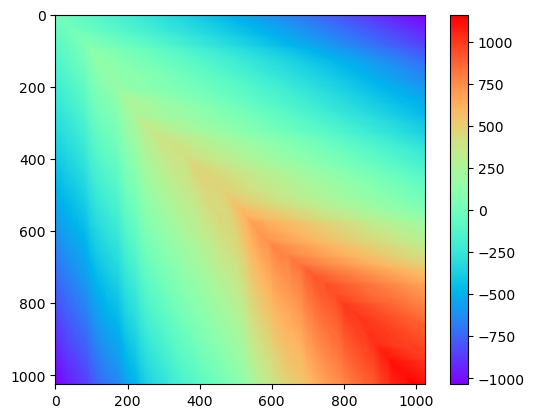

In [12]:
V_ans = V
print(f'Max score: {V_max}, Position: {x_max, y_max}')
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()

In [13]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1

width = 60
parts = len(seq_1)//width + 1
print(f'Max score: {V_max}, Position: {x_max, y_max}')
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

seq_1_ans = seq_1
seq_2_ans = seq_2
result_ans = result

Max score: 1160.0, Position: (1019, 987)
AT----GAACTGGAGTCTACGATGAGTGTACGAACGTCAGCTGGA-------ACAGGCTT
||    || ||  | | |||  ||  |     | | |||||||||        |||||||
ATTAGAGAGCTTAAATTTACCCTGGCT----CAGCATCAGCTGGATCTTATGCCAGGCTT

CCCA-CCAGGGTTGCTACTTATCATTTATTGTACGTTCAAAGGCGTGGTTTGTTTCTTGT
|||| |||||||||     ||| | |||||||||||||||||||||||        ||||
CCCATCCAGGGTTG-----TAT-AGTTATTGTACGTTCAAAGGCGTGG--------TTGT

GGCTGGTTCGATACAAGGTACCGATTATCAGGCCGCAAAATTAACACGTTACCTTTTGTA
||||| ||| |        |||||||  || | |   ||  || |||  ||   ||||| 
GGCTGCTTCCA-------GACCGATT-CCAAGTC---AAGATACCAC--TAAAATTTGT-

GGGGAAGGGTTTGAACCACGGAACTGACATCTTACAGACCCGCTCCCTCGCATCGTTATC
    ||||||  |||||           || |||||||||||||||||||||||||||||
----AAGGGTCAGAACC---------GTATTTTACAGACCCGCTCCCTCGCATCGTTATC

CG---GCCCCTAAAATAAAGAACTCGATAACTAACAATGGTCCCGAGGAAGGACAGGTAG
||   ||||||                   ||||| || |   |||||||||||||||||
CGTTAGCCCCT-------------------CTAACTATAG---CGAGGAAGGACAGGTAG

CAAGATATGAGCCCTCCTTTGGCG---ACTACA----AC

In [14]:
# checking calculation
score = 0
for i in range(len(seq_1)):
    if seq_1[i] == '-':
        if seq_1[i-1] == '-':
            score += g_e
        else:
            score += g_o
    elif seq_2[i] == '-':
        if seq_2[i-1] == '-':
            score += g_e
        else:
            score += g_o
    else:
        score += W[seq_1[i]][seq_2[i]]
print(score)

1160


# With stripe (banded)

In [15]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
V = V + float('-inf')
V[0][0] = 0
I = np.zeros((tile_size+1, tile_size+1))
I = I + float('-inf')
I[0][0] = 0
D = np.zeros((tile_size+1, tile_size+1))
D = D + float('-inf')
D[0][0] = 0

for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
#     V[0, i] = float('-inf')
#     V[i, 0] = float('-inf')
    D[0, i] = float('-inf')
    D[i, 0] = g_o + i*g_e
    I[0, i] = g_o + i*g_e
#     D[i, 0] = float('-inf')
#     I[0, i] = float('-inf')
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_2x = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -12.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -13.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -14.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 ...
 [-1032.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1033.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1034.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1035.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]]
Insertion matrix (Score when direction is left)
[[    0.   -13.   -14.   -15. ... -1033. -1034. -1035. -1036.]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 ...
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -in

In [16]:
path = 'output_score.txt'
f = open(path, 'w')

# start position of next PE stripe
column_start = 1
column_end = 1
V_max = -1000000
V_max_local = -1000000
x_max, y_max = 0, 0
x_max_local, y_max_local = 0, 0

for i in range(1, tile_size+1, num_PE):
    column = column_start # current row
    V_max_local = -1000000
    stripe_len = 0
    # print(f"{(i+3)//4}'th stripe start at column {column}")
    stripe_end = False
    # save min scores of 64 PEs in every position
    min_scores = []
    f.write(f'stripe {i//64} \n')
    while not stripe_end:
        # row index: i+j, column index:column
        # save scores of 64 PEs
        scores = []
        for j in range(num_PE):
            if i+j > tile_size:
                break
            # print(j, column)
            # anti-diagonal PE
            column_shift = column - j
            # PEs out of bound
            if (column_shift < column_start) or (column_shift > tile_size):
                # print('skip', column_shift, j)
                scores.append(-1000000)
                continue
                
            V_nxt = V[i+j-1][column_shift-1] + W[gene_1[i+j-1]][gene_2[column_shift-1]]
            I[i+j][column_shift] = max(V[i+j][column_shift-1]+g_o, I[i+j][column_shift-1]+g_e)
            D[i+j][column_shift] = max(V[i+j-1][column_shift]+g_o, D[i+j-1][column_shift]+g_e)
            V[i+j][column_shift] = max(V_nxt, I[i+j][column_shift], D[i+j][column_shift])
            scores.append(V[i+j][column_shift])
            # track max score
            if V[i+j][column_shift] >= V_max:
                V_max = V[i+j][column_shift]
                x_max, y_max = i+j, column_shift
            # local minimum for stripe end
            if V[i+j][column_shift] >= V_max_local:
                V_max_local = V[i+j][column_shift]
                x_max_local, y_max_local = i+j, column_shift
            # track direction
            if V[i+j][column_shift] == V_nxt:
                Trace[i+j][column_shift] = 1
                # 2 step diagonal
                if ((Trace_2x[i+j-1][column_shift-1] == 1) or (Trace_2x[i+j-1][column_shift-1] == 4)) and ((i+j-1) % 64 > 0):
                    Trace_2x[i+j][column_shift] = 4
                else:
                    Trace_2x[i+j][column_shift] = 1
            elif V[i+j][column_shift] == D[i+j][column_shift]:
                Trace[i+j][column_shift] = 2
                Trace_2x[i+j][column_shift] = 2
            elif V[i+j][column_shift] == I[i+j][column_shift]:
                Trace[i+j][column_shift] = 3
                Trace_2x[i+j][column_shift] = 3
            # direction of Trace_I
            if I[i+j][column_shift] == V[i+j][column_shift-1]+g_o:
                Trace_I[i+j][column_shift] = 1
            else:
                Trace_I[i+j][column_shift] = 0
            # direction of Trace_D
            if D[i+j][column_shift] == V[i+j-1][column_shift]+g_o:
                Trace_D[i+j][column_shift] = 1
            else:
                Trace_D[i+j][column_shift] = 0
        # if stripe end
        # working number of PEs amy < total number when last stripe
        max_in_PEs = max(scores)
        min_scores.append(max(scores))
        f.writelines(str(scores))
        f.write(' max ')
        f.write(str(max_in_PEs))
        f.write(' mins ')
        f.write(str(min(scores)))
        f.write('\n')
        # needs to end far than max_y
        if (max_in_PEs < V_max_local-y_drop) or (max_in_PEs == -1000000) or (stripe_len == 511):
            stripe_end = True
            column_end = column
            # print(max_in_PEs, V_max_local-y_drop)
            print(f"{i//64}'th stripe start at {column_start} end at column {column}, length {stripe_len}")
        # PE shift to next column
        column += 1
        stripe_len += 1
    # next stripe start position
    early_end = True
    # print('threshold:', V_max_local-y_drop, V_max_local, y_drop)
    for m in range(63, len(min_scores)-128):
        # print(min_scores[m], V_max_local-y_drop)
        if min_scores[m] > V_max_local-y_drop:
            column_start += m-63
            early_end = False
            break
    min_scores = [i for i in min_scores if i != -1000000]
    print(f'local max: {V_max_local}', f'local min: {min(min_scores)}', f'range: {V_max_local-min(min_scores)}')
    # all score in stripe < maximum
    if early_end:
        print('Can\'t find next start, use default 32')
        column_start += 40
        
    print('')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(f'Max score: {V_max}, Position: {x_max, y_max}')
f.close()

0'th stripe start at 1 end at column 363, length 362
local max: 70.0 local min: -171.0 range: 241.0

1'th stripe start at 1 end at column 431, length 430
local max: 152.0 local min: -90.0 range: 242.0

2'th stripe start at 1 end at column 512, length 511
local max: 169.0 local min: -136.0 range: 305.0

3'th stripe start at 1 end at column 512, length 511
local max: 272.0 local min: -200.0 range: 472.0

4'th stripe start at 39 end at column 550, length 511
local max: 362.0 local min: -201.0 range: 563.0

5'th stripe start at 112 end at column 623, length 511
local max: 421.0 local min: -66.0 range: 487.0

6'th stripe start at 144 end at column 655, length 511
local max: 488.0 local min: -65.0 range: 553.0

7'th stripe start at 184 end at column 695, length 511
local max: 528.0 local min: -26.0 range: 554.0

8'th stripe start at 232 end at column 743, length 511
local max: 688.0 local min: 67.0 range: 621.0

9'th stripe start at 362 end at column 873, length 511
local max: 778.0 local mi

In [17]:
# print(V[0:10,0:10])
# print(V[63:66,0:10])
# print(Trace[960:970,818:828])
# print(Trace_I[960:970,818:828])
# print(Trace_D[960:970,818:828])
# print(I[0:10,0:10])
# print(D[0:10,0:10])
# print(D[128:130,38:50])

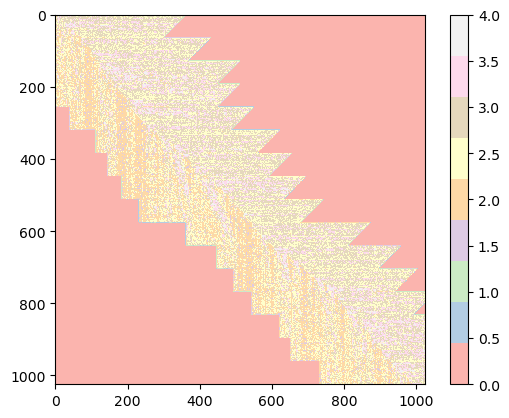

In [18]:
plt.imshow(Trace_2x[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

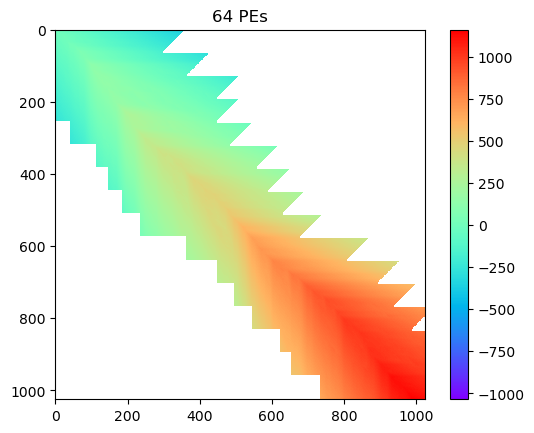

Max score: 1160.0 Position: (1019, 987)
Local Max: 1160.0 Position: (1019, 987)


In [19]:
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.title(f'{num_PE} PEs')
plt.show()
print('Max score:', V_max, f'Position: {x_max, y_max}')
print('Local Max:', V_max_local, f'Position: {x_max_local, y_max_local}')

In [20]:
f = open(f'./verilog/test_data/align_{seed}.txt', 'w')
f2 = open('align_xy.txt', 'w')

seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

# Trace cases
dir_list = [0,0,0,0,0,0,0,0,0,0,0,0]

t = 0

x, y = x_max_local, y_max_local
while(x != 0) and (y != 0):
    t += 1
    f2.write(f"{x} {y} T:{Trace[x][y]} D:{Trace_D[x][y]} I:{Trace_I[x][y]}\n")
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y, gene_1[x-1], gene_2[y-1])
        f.write(f"{Trace[x][y]}\n")
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("2\n")
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("3\n")
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1
    # count direction type
    index = (Trace[x,y] - 1)*4 + Trace_I[x,y]*2 + Trace_D[x,y]
    dir_list[int(index)] += 1

parts = len(seq_1)//width + 1
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

print(seq_1 == seq_1_ans)
print(seq_2 == seq_2_ans)
print(f'length: {len(seq_1)}')
print(dir_list)
print(f"time: {t}")
f.close()
f2.close()

AT----GAACTGGAGTCTACGATGAGTGTACGAACGTCAGCTGGA-------ACAGGCTT
||    || ||  | | |||  ||  |     | | |||||||||        |||||||
ATTAGAGAGCTTAAATTTACCCTGGCT----CAGCATCAGCTGGATCTTATGCCAGGCTT

CCCA-CCAGGGTTGCTACTTATCATTTATTGTACGTTCAAAGGCGTGGTTTGTTTCTTGT
|||| |||||||||     ||| | |||||||||||||||||||||||        ||||
CCCATCCAGGGTTG-----TAT-AGTTATTGTACGTTCAAAGGCGTGG--------TTGT

GGCTGGTTCGATACAAGGTACCGATTATCAGGCCGCAAAATTAACACGTTACCTTTTGTA
||||| ||| |        |||||||  || | |   ||  || |||  ||   ||||| 
GGCTGCTTCCA-------GACCGATT-CCAAGTC---AAGATACCAC--TAAAATTTGT-

GGGGAAGGGTTTGAACCACGGAACTGACATCTTACAGACCCGCTCCCTCGCATCGTTATC
    ||||||  |||||           || |||||||||||||||||||||||||||||
----AAGGGTCAGAACC---------GTATTTTACAGACCCGCTCCCTCGCATCGTTATC

CG---GCCCCTAAAATAAAGAACTCGATAACTAACAATGGTCCCGAGGAAGGACAGGTAG
||   ||||||                   ||||| || |   |||||||||||||||||
CGTTAGCCCCT-------------------CTAACTATAG---CGAGGAAGGACAGGTAG

CAAGATATGAGCCCTCCTTTGGCG---ACTACA----ACACTTTTCTCTAGTGGCGGG--
|||||||  ||||||||||

In [21]:
f = open(f'./verilog/test_data/align_{seed}.txt', 'w')

# With 2 step diagonal
Trace = Trace_2x

seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

# Trace cases
dir_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

t = 0

x, y = x_max_local, y_max_local
while(x != 0) and (y != 0):
    t += 1
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y, gene_1[x-1], gene_2[y-1])
        f.write(f"{Trace[x][y] % 4}\n")
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
        elif Trace[x][y] == 4:
            seq_1 = gene_1[x-2] + gene_1[x-1] + seq_1
            seq_2 = gene_2[y-2] + gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            if gene_1[x-2] == gene_2[y-2]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-2, y-2
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("2\n")
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("3\n")
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1
    # count direction type
    index = (Trace[x,y] - 1)*4 + Trace_I[x,y]*2 + Trace_D[x,y]
    dir_list[int(index)] += 1

parts = len(seq_1)//width + 1
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

print(seq_1 == seq_1_ans)
print(seq_2 == seq_2_ans)
print(f'length: {len(seq_1)}')
print(dir_list)
print(f"time: {t}")
f.close()

AT----GAACTGGAGTCTACGATGAGTGTACGAACGTCAGCTGGA-------ACAGGCTT
||    || ||  | | |||  ||  |     | | |||||||||        |||||||
ATTAGAGAGCTTAAATTTACCCTGGCT----CAGCATCAGCTGGATCTTATGCCAGGCTT

CCCA-CCAGGGTTGCTACTTATCATTTATTGTACGTTCAAAGGCGTGGTTTGTTTCTTGT
|||| |||||||||     ||| | |||||||||||||||||||||||        ||||
CCCATCCAGGGTTG-----TAT-AGTTATTGTACGTTCAAAGGCGTGG--------TTGT

GGCTGGTTCGATACAAGGTACCGATTATCAGGCCGCAAAATTAACACGTTACCTTTTGTA
||||| ||| |        |||||||  || | |   ||  || |||  ||   ||||| 
GGCTGCTTCCA-------GACCGATT-CCAAGTC---AAGATACCAC--TAAAATTTGT-

GGGGAAGGGTTTGAACCACGGAACTGACATCTTACAGACCCGCTCCCTCGCATCGTTATC
    ||||||  |||||           || |||||||||||||||||||||||||||||
----AAGGGTCAGAACC---------GTATTTTACAGACCCGCTCCCTCGCATCGTTATC

CG---GCCCCTAAAATAAAGAACTCGATAACTAACAATGGTCCCGAGGAAGGACAGGTAG
||   ||||||                   ||||| || |   |||||||||||||||||
CGTTAGCCCCT-------------------CTAACTATAG---CGAGGAAGGACAGGTAG

CAAGATATGAGCCCTCCTTTGGCG---ACTACA----ACACTTTTCTCTAGTGGCGGG--
|||||||  ||||||||||

In [22]:
f1 = open(f'./verilog/test_data/gene_1_array_{seed}.txt', 'w')
f2 = open(f'./verilog/test_data/gene_2_array_{seed}.txt', 'w')
d = {'A':0, 'C':1, 'G':2, 'T':3}

for i in range(tile_size):
    f1.write(f'{d[gene_1[i]]}\n')
    f2.write(f'{d[gene_2[i]]}\n')

f1.close()
f2.close()